# Setup

In [1]:
import os
import numpy as np
import PIL
import tensorflow as tf
from tensorflow import keras
from google.cloud import storage
bucket_name = 'iot-lego-sorter.appspot.com'
folder = 'datasets'

localDir = 'images/lego/'

storage_client = storage.Client.from_service_account_json('service_account.json')
bucket = storage_client.bucket(bucket_name)

List available buckets.

In [2]:
buckets = list(storage_client.list_buckets())
print(buckets)

[<Bucket: iot-lego-sorter.appspot.com>, <Bucket: staging.iot-lego-sorter.appspot.com>]


# Download files from Google Storage

Get available files in datasets.

In [3]:
blobs = storage_client.list_blobs(bucket_name, prefix=folder)
fileNameByBrickId = {}

for blob in blobs:
    nameNoFolder = blob.name[len(folder)+1:]
    split = nameNoFolder.split('/')
    
    if(len(split) > 1):
        id = split[0];
        fileDir = blob.name;
        
        if(id in fileNameByBrickId):
            fileNameByBrickId[id].append(fileDir)
        else:
            fileNameByBrickId[id] = [fileDir]
print('Got all filenames')

Got all filenames


In [4]:
def downloadFile(fileName):
    nameNoFolder = fileName[len(folder)+1:]
    testFileDir = localDir + nameNoFolder
    testDir = os.path.dirname(testFileDir)

    if not os.path.exists(testDir):
        os.makedirs(testDir)
    blob = bucket.blob(fileName)
    blob.download_to_filename(testFileDir)
    
    return testFileDir

In [5]:
localFileNameByBrickId = {}
for key in fileNameByBrickId.keys():
    print(key)
    localFileNameByBrickId[key] = []
    listLenStr = str(len(fileNameByBrickId[key]))
    for index, fileName in enumerate(fileNameByBrickId[key]):
        print(str(index+1).zfill(len(listLenStr)) + '/' + listLenStr + ' - ' + fileName + (' ' * 256), end='\r')
        localFileNameByBrickId[key].append(downloadFile(fileName))
    print(listLenStr + '/' + listLenStr + ' - Finished downloading' + (' ' * 256))
print('\nFinished all downloads')

3001
1621/1621 - Finished downloading                                                                                                                                                                                                                                                                                                       
3003
1322/1322 - Finished downloading                                                                                                                                                                                                                                                                                                       
3004
1627/1627 - Finished downloading                                                                                                                                                                                                                                                                                                       



# Make images into multidimensional arrays

In [6]:
def convertImageToArray(fileName):
    an_image = PIL.Image.open(fileName).convert('L')
    image_sequence = an_image.getdata()
    return np.array(image_sequence)

In [7]:
IndexToBrickId = {}
brickIdIndexes = []
images = []
realWorldBrickIdIndexes = []
realWorldImages = []

for index, key in enumerate(localFileNameByBrickId.keys()):
    print(key)
    IndexToBrickId[index] = key
    listLenStr = str(len(localFileNameByBrickId[key]))
    for index2, fileName in enumerate(localFileNameByBrickId[key]):
        print(str(index2+1).zfill(len(listLenStr)) + '/' + listLenStr + ' - ' + fileName + (' ' * 256), end='\r')
        if ("_belt" in fileName):
            realWorldBrickIdIndexes.append(index)
            realWorldImages.append(convertImageToArray(fileName))
        else:
            brickIdIndexes.append(index)
            images.append(convertImageToArray(fileName))
    print(listLenStr + '/' + listLenStr + ' - Finished converting' + (' ' * 256))
print('\nFinished converting all')

3001


1621/1621 - Finished converting                                                                                                                                                                                                                                                                                                           
3003
1322/1322 - Finished converting                                                                                                                                                                                                                                                                                                           
3004
1627/1627 - Finished converting                                                                                                                                                                                                                                                                                                         

In [8]:
print(IndexToBrickId[0])
print(brickIdIndexes[0])
print(images[0])
print(len(images[0]))
print("Number of classes: " + str(len(IndexToBrickId)))
print("Number of y values: " + str(len(brickIdIndexes)))
print("Number of X values: " + str(len(images)))
print("Number of RealWorld y values: " + str(len(realWorldBrickIdIndexes)))
print("Number of RealWorld X values: " + str(len(realWorldImages)))

3001
0
[135 136 137 ... 130 130 129]
4096
Number of classes: 3
Number of y values: 4503
Number of X values: 4503
Number of RealWorld y values: 67
Number of RealWorld X values: 67


# Machine Learning

## Prepare data

In [9]:
# Convert to numpy arrays
images = np.array(images)
brickIdIndexes = np.array(brickIdIndexes)
realWorldImages = np.array(realWorldImages)
realWorldBrickIdIndexes = np.array(realWorldBrickIdIndexes)

# Normalize datapoints to range from 0.0 to 1.0 instead of 0 to 255
images = images / 255.0
realWorldImages = realWorldImages / 255.0

In [10]:
# Print to check if the data looks alright
print(images[0])
print(realWorldImages[0])

[0.52941176 0.53333333 0.5372549  ... 0.50980392 0.50980392 0.50588235]
[0.76470588 0.76862745 0.77254902 ... 0.81568627 0.81568627 0.81568627]


### Split Dataset into train(67%), test(16,5%) and validate(16,5%)

In [11]:
from sklearn.model_selection import train_test_split

# Using SciKitLearn method to spilt randomly, the method name is not the best but it just splits a dataset in two parts
X_train, X_testAndVal, y_train, y_testAndVal = train_test_split(images, brickIdIndexes, test_size=0.33, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_testAndVal, y_testAndVal, test_size=0.5, random_state=43)

# RW is short for Real World, these are images taken on the sorting machine itself
X_trainRW, X_testAndValRW, y_trainRW, y_testAndValRW = train_test_split(realWorldImages, realWorldBrickIdIndexes, test_size=0.33, random_state=42)
X_testRW, X_valRW, y_testRW, y_valRW = train_test_split(X_testAndValRW, y_testAndValRW, test_size=0.5, random_state=43)

# Adding Real World data to data sets, for even distribution compared to ordinary images
X_train = np.concatenate((X_train, X_trainRW))
y_train = np.concatenate((y_train, y_trainRW))

X_val = np.concatenate((X_val, X_valRW))
y_val = np.concatenate((y_val, y_valRW))

X_test = np.concatenate((X_test, X_testRW))
y_test = np.concatenate((y_test, y_testRW))

print(f"Training datapoints: {len(X_train)}")
print(f"Validation datapoints: {len(X_val)}")
print(f"Test datapoints: {len(X_test)}")

Training datapoints: 3061
Validation datapoints: 755
Test datapoints: 754


## Create Model

In [12]:
# Build model function for wrapping in scikit learn
def build_model(n_hidden=3, n_neurons=80, activation="selu", optimizer="SGD", learningRate=0.1, loss="sparse_categorical_crossentropy"):
    model = keras.models.Sequential()
    input_shape = [len(images[0])]
    
    #InputLayer
    model.add(keras.layers.InputLayer(input_shape=input_shape))
    
    #Hidden Layers
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation=activation))
    
    #Output Layer
    number_of_classes = len(IndexToBrickId)
    model.add(keras.layers.Dense(number_of_classes, activation="softmax"))
    
    #Set optimizer with learing rate
    if optimizer == "Adam":
        optimizer = keras.optimizers.Adam(learning_rate=learningRate)
    elif optimizer == "Nadam":
        optimizer = keras.optimizers.Nadam(learning_rate=learningRate)
    elif optimizer == "Adamax":
        optimizer = keras.optimizers.Adamax(learning_rate=learningRate)
    else:
        #Default optimizer SGD
        optimizer = keras.optimizers.SGD(learning_rate=learningRate)
    
    #Compile
    model.compile(loss=loss,
              optimizer=optimizer,
              metrics=["accuracy"])
    
    return model

In [13]:
# Wrap the Keras model in a Scikit-Learn KerasRegressor.
keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)

#### Callbacks

In [14]:
# Define callbacks
#callbacks = [keras.callbacks.ReduceLROnPlateau(factor=0.9, patience=3, min_lr=0.001)]
callbacks = [keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=5, verbose=0,
    mode='auto', baseline=None, restore_best_weights=True
)]

## Train model

### Randomized Search to find more optimal hyper parameters

In [15]:
from sklearn.model_selection import RandomizedSearchCV

# Define hyperparameter sets and ranges to explore
param_distribs = {
    "n_hidden": [1, 2, 3, 4, 5],
    "n_neurons": list(range(10, 150)),
    "activation": ["relu", "selu"],
    "optimizer": ["Adam", "SGD", "Adamax", "Nadam"],
    "learningRate": [0.0005, 0.001, 0.002, 0.004, 0.006, 0.008, 0.01, 0.02, 0.04, 0.08, 0.1, 0.2, 0.4, 0.6]
}

# Create an instance of RandomizedSearchCV
rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, n_iter=20, n_jobs=-1, verbose=10)

# Run Randomized Search
rnd_search_cv.fit(X_train, y_train, epochs=60,
                  validation_data=(X_val, y_val),
                  callbacks=[keras.callbacks.EarlyStopping(patience=5)])


Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  7.2min finished


Epoch 1/60
96/96 [==============================] - 0s 5ms/step - loss: 1.0191 - accuracy: 0.5008 - val_loss: 0.9438 - val_accuracy: 0.6358
Epoch 2/60
96/96 [==============================] - 0s 3ms/step - loss: 0.8028 - accuracy: 0.6988 - val_loss: 0.6804 - val_accuracy: 0.8570
Epoch 3/60
96/96 [==============================] - 0s 3ms/step - loss: 0.5967 - accuracy: 0.8383 - val_loss: 0.4892 - val_accuracy: 0.8768
Epoch 4/60
96/96 [==============================] - 0s 3ms/step - loss: 0.4328 - accuracy: 0.8804 - val_loss: 0.4039 - val_accuracy: 0.8927
Epoch 5/60
96/96 [==============================] - 0s 3ms/step - loss: 0.3103 - accuracy: 0.9193 - val_loss: 0.2558 - val_accuracy: 0.9192
Epoch 6/60
96/96 [==============================] - 0s 3ms/step - loss: 0.2523 - accuracy: 0.9392 - val_loss: 0.2004 - val_accuracy: 0.9748
Epoch 7/60
96/96 [==============================] - 0s 3ms/step - loss: 0.2059 - accuracy: 0.9592 - val_loss: 0.1681 - val_accuracy: 0.9854
Epoch 8/60
96/96 [==

RandomizedSearchCV(estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x13bf36ac0>,
                   n_iter=20, n_jobs=-1,
                   param_distributions={'activation': ['relu', 'selu'],
                                        'learningRate': [0.0005, 0.001, 0.002,
                                                         0.004, 0.006, 0.008,
                                                         0.01, 0.02, 0.04, 0.08,
                                                         0.1, 0.2, 0.4, 0.6],
                                        'n_hidden': [1, 2, 3, 4, 5],
                                        'n_neurons': [10, 11, 12, 13, 14, 15,
                                                      16, 17, 18, 19, 20, 21,
                                                      22, 23, 24, 25, 26, 27,
                                                      28, 29, 30, 31, 32, 33,
                                                      34, 35, 36, 37, 38, 3

In [16]:
rnd_search_cv.best_params_

{'optimizer': 'Adamax',
 'n_neurons': 85,
 'n_hidden': 3,
 'learningRate': 0.0005,
 'activation': 'relu'}

In [17]:
# Display the score of the best model (note that Scikit-Learn computes a negative value)
rnd_search_cv.best_score_

-0.07457784023135901

## Evaluate

In [18]:
# Get the model for the best estimator, and evaluate it on the test set.
rnd_search_model = rnd_search_cv.best_estimator_.model
rnd_search_model.evaluate(X_test, y_test)

24/24 [==============================] - 0s 2ms/step - loss: 0.0807 - accuracy: 0.9894


[0.08072535693645477, 0.9893898963928223]

In [19]:
# Evaluate only on Real world data including the part that was in the training and validation set
rnd_search_model.evaluate(realWorldImages, realWorldBrickIdIndexes)

3/3 [==============================] - 0s 1ms/step - loss: 1.6386 - accuracy: 0.7313


[1.6386420726776123, 0.7313432693481445]

In [20]:
# Evaluate only on Real world data in the test, this is a very small sample size
rnd_search_model.evaluate(X_testRW, y_testRW)

1/1 [==============================] - 0s 1ms/step - loss: 2.8532 - accuracy: 0.6364


[2.8531687259674072, 0.6363636255264282]

# Save model
### Save and export as tflite file for use on the Raspberry Pi

In [21]:
# Recreate the model with the best parameters:
# Best yet: {'optimizer': 'Adamax', 'n_neurons': 123, 'n_hidden': 1, 'learningRate': 0.001 'activation': 'selu'}
bestModel = build_model(n_hidden=1, n_neurons=123, activation="selu", optimizer="Adamax", learningRate=0.001)

In [22]:
# Retrain model 
bestModel.fit(X_train, y_train, epochs=60,
                  validation_data=(X_val, y_val),
                  callbacks=[keras.callbacks.EarlyStopping(patience=5)])

Epoch 1/60
96/96 [==============================] - 0s 4ms/step - loss: 1.3839 - accuracy: 0.5652 - val_loss: 0.7157 - val_accuracy: 0.6715
Epoch 2/60
96/96 [==============================] - 0s 4ms/step - loss: 0.5982 - accuracy: 0.8389 - val_loss: 0.5479 - val_accuracy: 0.8675
Epoch 3/60
96/96 [==============================] - 0s 3ms/step - loss: 0.4726 - accuracy: 0.8651 - val_loss: 0.4420 - val_accuracy: 0.8543
Epoch 4/60
96/96 [==============================] - 0s 4ms/step - loss: 0.3939 - accuracy: 0.8928 - val_loss: 0.3676 - val_accuracy: 0.8980
Epoch 5/60
96/96 [==============================] - 0s 4ms/step - loss: 0.3446 - accuracy: 0.9033 - val_loss: 0.2831 - val_accuracy: 0.9205
Epoch 6/60
96/96 [==============================] - 0s 4ms/step - loss: 0.2853 - accuracy: 0.9291 - val_loss: 0.2359 - val_accuracy: 0.9404
Epoch 7/60
96/96 [==============================] - 0s 4ms/step - loss: 0.2415 - accuracy: 0.9497 - val_loss: 0.2246 - val_accuracy: 0.9682
Epoch 8/60
96/96 [==

In [23]:
# Evaluate on real world test data, just to make sure that all is as it should be
bestModel.evaluate(X_testRW, y_testRW)

1/1 [==============================] - 0s 1ms/step - loss: 2.0416 - accuracy: 0.7273


[2.0416259765625, 0.7272727489471436]

### Save model as ordinary Tensorflow

In [24]:
model_version = "07"
model_name = "LEGO_sorting_model"
model_path = os.path.join(model_name, model_version)
tf.saved_model.save(bestModel, model_path)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: LEGO_sorting_model/07/assets


### Create TFLite file for Raspberry PI

In [25]:
converter = tf.lite.TFLiteConverter.from_saved_model(model_path)
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS,
                                       tf.lite.OpsSet.SELECT_TF_OPS]
tflite_model = converter.convert()
open("converted_model.tflite", "wb").write(tflite_model)

2018892

# Results, what I found and what I tried

Jeg beskriver her de iterationer jeg har været igennem, hvilke ændringer jeg lavede og hvilke resultater jeg så.

## First run
#### Input Data
I alt 4096 billeder og tre klasser 3001 (2x4), 3003 (2x2) og 3004(1x2)
Datasættet er tilfældigt separeret i validation, testing og træning.

#### Model
Three Hidden layers med 80 neurons og selu activation

Output layer med softmax

Loss function: sparse_categorical_crossentropy

Optimizer: sgd (Stochastic gradient descent)

#### Results
(Batch size 32)
Efter 48 epochs er alle validation beregnet med en accuracy på 1.00 (100% korrekt) 
Efter 49 epochs er alle trænings billeder lige ledes beregnet med en accuracy på 1.00 (100% korrekt)
Efter alle 60 epochs i evalueringen er den også 100% korrekt på test sættet.

#### Thoughts
De resultater er ikke nemme at forbedre sådan som det ser ud men det kunne godt være der er nogle problemmer med test data vi skal kigge på.
Hvilke problemmer tror jeg der er:
Jeg tror at problemmet er at vi har taget billederne hvor vi har lagt klodsen på en roterende platform og så taget 200 billeder. Dette gør at billederne ligner meget hindanden det vil sige at den selv på validerings og test data bliver belønnet for at være lidt overfitting fordi billedet måske kun er marginalt anderledes end et billede som den har set i trainingssættet. 

#### Improvements
Det kunne være intresant at udtage en klods fra hver klasse og bruge den til validering og test så den ikke har set den klods før i trænings sættet. Der mangler dog et Batch id eller lign for at kunne gøre dette.

Man bør nok også overveje at tilføje flere forskellige klodser (lige nu er der to af hver type) og lidt færre per klods måske 50 istedet for de 200 så vi kan værre sikkre på at den generalizere bedre.

#### Learning curve diagram
En smule ujævn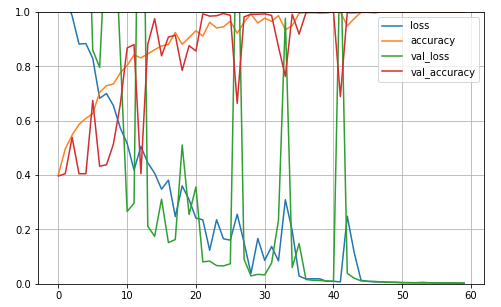

## Second Run
### Goal
Få en pænere mere konstant learning-curve

### Changes
Learning rate til 0.005 istedet for de 0.01
For at få en lidt langsommere learning rate så den ikke hopper så meget frem og tilbage

### Result
Efter 50 epochs er den nede på 100 % accuracy på validation data. Og for trainning går der nu kun 47 epochs.
Og ikke midst er Learning kurven blevet meget mere jævn. Jeg tænker derfor at dette er en lille forbedring. 
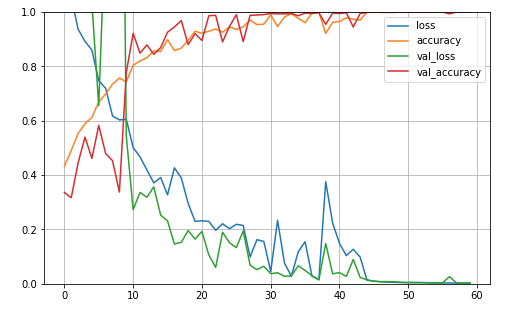

### Improvements
Jeg kører en masse epochs hvor der ikke er megen udvikling, det er der ingen grund til. Måske skulle man implementere early stopping. Man kunne også se på noget learning rate scheduling for at se om man kan optimere den endnu mere. og evt noget grid eller random search hvor man kunne prøve nogle forskellige.


# Third run
### Goal 
Tilføj learning rate schedueling, i håbet om at forbedre indlæringskurven.
### Changes 
Tilføjede ReduceLROnPlateau learning rate schedueling som en callback
### Result 
På resultaterne kunne jeg ikke se nogle forbedringer, prøvede en del forskellige værdier. Men der var ikke rigtig noget der synderligt forbedrede resultaterne 

Her er et eksempel med 
Initial learning rate: 0.008
factor=0.9
patience=3
min_lr=0.001

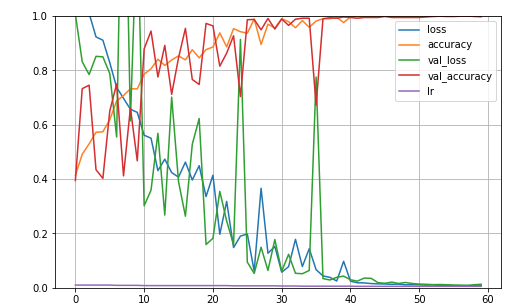

### Imporvements
Det kunne måske give bedre mening at finde nogle bedre paramettre med enten GridSearch eller RandomSearchCV. Men for nu vil jeg lige se bort fra dette.



# Fourth run
#### Goal
Mere effektiv træning

#### Changes
Tilføjede Early stopping Callback

#### Result 
Fordi min Early stopping evaluere Loss og ikke accuracy, stopper den aldrig før fordi den bliver ved med at forbedre sig en smule for hver af de 60 epochs. 


# Fifth run 
#### Goal 
Test Data der afspejler virkligheden. 

#### Changes
Da dataen som jeg har trænnet på entil videre har været meget ens, har vi valgt at tilføje nogle flere billeder til datasetet for at dette afspejler virkligheden bedre. Vi har to dele af vores system den ene en roterende platform til at kræere datasettet og så et transportbånd hvor det senere skal bruges til at klassificere klodser med henblik på sortingering. Vi har altså lavet nogle billeder af brikken hvor den ligger på transport båndet, som derfor bedre afspjler virkligheden. Vi har gjort dette da den høje accuracy vi havde i starten gjorde os usikkre på om dataen måske var for ens.

Jeg har i første omgang valgt at bruge denne data til evaluation

#### Result
Som saget har jeg brugt dataen til evaluation og det ser ikke helt så godt ud kun 49% accuracy, det er ikke så godt

#### Improvements
Jeg vil prøve at smide en del at dette realworld data i training, og validation. Så den kan lære denne lidt anderledes udseende data at kende.


# Sixth run
#### Goal 
Få modellen til bedre at ramme rigtig på realworld data

#### Changes 
Jeg har fordelt Real world dataen ud på de forskellige trainingssæt dele med samme fordeling som det andet. 

#### Result
Dette giver en accuracy på 64% på realworld data.

#### Improvements
Du kunne være intresant om man kunne optimere dette, måske med noget hyper parameter tuning...

# Seventh run

#### Goal 
Brug randomSearchCV til at tune hyper parameters.

#### Changes
Wrappet det at bygge modelen i en Scikit Kearas Regressor, derefter brugt Random search CV til at finde den bedste model. 

#### Result
Jeg kørte den i 150 iterationer, af dem den prøvede var den bedste den med disse hyper parameters:
```
{'optimizer': 'Adamax',
 'n_neurons': 123,
 'n_hidden': 1,
 'learningRate': 0.001,
 'activation': 'selu'}
```
 
Ved evalueringen gav den 99,47% accuracy på test data og 73,1% på real world data. Hvis jeg kun tager den del af Real world test data som er en del af test data får jeg 72,7% accuracy
 
#### Improvements
Den er ret dårlig til real world data i forhold til test dataen, det kunne derfor godt tyde på at vi enten skal have mere af dette. Eller alternativt at vi skal priotere det lidt højere, så Real world data har en større indflydelse på scoren.
